# Tutorial: Dispatcher

This notebook demonstrates how to use dispatcher.

In [1]:
import numpy as np
from epymodelingsuite.config_loader import load_basemodel_config_from_file, load_sampling_config_from_file, load_calibration_config_from_file, load_output_config_from_file
from epymodelingsuite.schema.general import validate_cross_config_consistency

In [2]:
from epymodelingsuite.dispatcher.builder import dispatch_builder
from epymodelingsuite.dispatcher.runner import dispatch_runner
from epymodelingsuite.dispatcher.output import dispatch_output_generator

In [3]:
# Used to collect metrics during execution
from epymodelingsuite.telemetry import ExecutionTelemetry, create_workflow_telemetry

In [4]:
from epydemix.visualization import plot_quantiles
from matplotlib import pyplot as plt
from io import StringIO
import pandas as pd
import numpy as np
import gzip

In [5]:
# import logging
# import sys

# root = logging.getLogger()
# if root.handlers:
#     root.handlers.clear()

# logging.basicConfig(
#     level=logging.INFO,
#     stream=sys.stdout,
#     format="%(asctime)s %(name)s %(levelname)s: %(message)s",
# )

***
## Loading configs

In [6]:
basemodel_config_sampling = load_basemodel_config_from_file("data/flu_round05_basemodel_sampling.yml")
basemodel_config_calibration = load_basemodel_config_from_file("data/flu_round05_basemodel_calibration.yml")
basemodel_config_standalone = load_basemodel_config_from_file("data/basic_basemodel_standalone.yml")

In [7]:
sampling_config = load_sampling_config_from_file("data/flu_round05_modelset_sampling.yml")

In [8]:
calibration_config = load_calibration_config_from_file("data/flu_round05_modelset_calibration.yml")

In [9]:
output_config = load_output_config_from_file("data/basic_output.yaml")

In [10]:
# Override calibration settings temporarily
calibration_config.modelset.calibration.strategy.options['num_particles'] = 20
calibration_config.modelset.calibration.strategy.options['num_generations'] = 1

In [11]:
calibration_config.modelset.calibration.projection.n_trajectories = 10

***
## Validate config consistency

In [12]:
validate_cross_config_consistency(basemodel_config_sampling, sampling_config)

In [13]:
validate_cross_config_consistency(basemodel_config_calibration, calibration_config)

***
## Dispatcher - Builder

In [14]:
with ExecutionTelemetry() as builder_telemetry_sampling:
    builder_output_sampling = dispatch_builder(basemodel_config=basemodel_config_sampling, sampling_config=sampling_config)

In [16]:
print(builder_telemetry_sampling)

Telemetry Summary
Generated: 2025-11-07 16:47:21
Stage: Builder

CONFIGURATION
------------------------------------------------------------
Populations: 2 (United_States_Massachusetts, United_States_New_York)
  Age groups: 5 (0-4, 5-17, 18-49, 50-64, 65+)
Timespan: StartDateTypeEnum.sampled to 2025-05-31 (dt=1.0)
Random seed: 42

BUILDER STAGE
------------------------------------------------------------
Duration: 3.1s
Models created: 200
Peak memory: 224.9 MB

SUMMARY
------------------------------------------------------------
Total duration: 3.1s
Peak memory: 224.9 MB
CPU time: 7.0s (user), 0.2s (system)



In [17]:
with ExecutionTelemetry() as builder_telemetry_calibration:
    builder_output_calibration = dispatch_builder(basemodel_config=basemodel_config_calibration, calibration_config=calibration_config)

In [18]:
print(builder_telemetry_calibration)

Telemetry Summary
Generated: 2025-11-07 16:47:25
Stage: Builder

CONFIGURATION
------------------------------------------------------------
Populations: 2 (United_States_Massachusetts, United_States_New_York)
  Age groups: 5 (0-4, 5-17, 18-49, 50-64, 65+)
Timespan: StartDateTypeEnum.calibrated to 2025-05-31 (dt=1.0)
Random seed: 42

Calibration:
  Fitting window: 2024-09-15 to 2025-05-17
  Distance function: rmse

BUILDER STAGE
------------------------------------------------------------
Duration: 1.3s
Models created: 2
Peak memory: 227.8 MB

SUMMARY
------------------------------------------------------------
Total duration: 1.3s
Peak memory: 227.8 MB
CPU time: 7.4s (user), 0.3s (system)



In [19]:
with ExecutionTelemetry() as builder_telemetry_standalone:
    builder_output_standalone = dispatch_builder(basemodel_config=basemodel_config_standalone)

In [20]:
print(builder_telemetry_standalone)

Telemetry Summary
Generated: 2025-11-07 16:47:26
Stage: Builder

CONFIGURATION
------------------------------------------------------------
Populations: 1 (US-MA)
  Age groups: 5 (0-4, 5-17, 18-49, 50-64, 65+)
Timespan: 2024-08-05 to 2025-08-05 (dt=0.2)
Random seed: 42

BUILDER STAGE
------------------------------------------------------------
Duration: 0.6s
Models created: 1
Peak memory: 227.8 MB

SUMMARY
------------------------------------------------------------
Total duration: 0.6s
Peak memory: 227.8 MB
CPU time: 7.6s (user), 0.3s (system)



***
## Dispatcher - Runner

In [21]:
with ExecutionTelemetry() as runner_telemetry_sampling:
    runner_output_sampling = dispatch_runner(builder_output_sampling[0])

In [22]:
runner_output_sampling = dispatch_runner(builder_output_sampling[0])

In [23]:
print(runner_telemetry_sampling)

Telemetry Summary
Generated: 2025-11-07 16:47:38
Stage: Runner

RUNNER STAGE
------------------------------------------------------------
Total duration: 3.2s

United_States_Massachusetts (primary_id: 0):
  Simulation: 3.2s

Peak memory: 230.7 MB

SUMMARY
------------------------------------------------------------
Total duration: 3.2s
Peak memory: 230.7 MB
CPU time: 10.8s (user), 0.3s (system)



In [24]:
with ExecutionTelemetry() as runner_telemetry_calibration0:
    runner_output_calibration0 = dispatch_runner(builder_output_calibration[0])

Starting ABC-SMC with 20 particles and 1 generations

Generation 1/1 (epsilon: inf)
	Accepted 20/20 (acceptance rate: 100.00%)
	Elapsed time: 00:00:09


In [25]:
# runner_output_calibration0.results

In [26]:
# with ExecutionTelemetry() as runner_telemetry_calibration1:
#     runner_output_calibration1 = dispatch_runner(builder_output_calibration[1])

In [28]:
print(runner_telemetry_calibration0)

Telemetry Summary
Generated: 2025-11-07 16:48:34
Stage: Runner

RUNNER STAGE
------------------------------------------------------------
Total duration: 13.9s

United_States_Massachusetts (primary_id: 0):
  Calibration: 9.2s
    Strategy: smc (20 particles, 1 generations)
  Projection: 4.7s
    Trajectories: 10/10 successful

Peak memory: 238.9 MB

SUMMARY
------------------------------------------------------------
Total duration: 13.9s
Peak memory: 238.9 MB
CPU time: 27.7s (user), 0.3s (system)



In [29]:
with ExecutionTelemetry() as runner_telemetry_standalone:
    runner_output_standalone = dispatch_runner(builder_output_standalone)

In [31]:
print(runner_telemetry_standalone)

Telemetry Summary
Generated: 2025-11-07 16:48:46
Stage: Runner

RUNNER STAGE
------------------------------------------------------------
Total duration: 8.3s

United_States_Massachusetts (primary_id: 0):
  Simulation: 8.3s

Peak memory: 246.5 MB

SUMMARY
------------------------------------------------------------
Total duration: 8.3s
Peak memory: 246.5 MB
CPU time: 36.0s (user), 0.3s (system)



***
## Dispatcher - Output Generator

In [32]:
with ExecutionTelemetry() as output_telemetry_calibration:
    # Generate outputs for calibration projection results
    output_files = dispatch_output_generator(calibrations=[runner_output_calibration0], output_config=output_config)

In [33]:
print(output_telemetry_calibration)

Telemetry Summary
Generated: 2025-11-07 16:48:47
Stage: Output

OUTPUT STAGE
------------------------------------------------------------
Duration: 0.8s
Files generated: 7
  - quantiles_compartments.csv.gz (247.5 KB)
  - quantiles_transitions.csv.gz (6.2 KB)
  - trajectories_compartments.csv.gz (1.9 KB)
  - trajectories_transitions.csv.gz (52.0 KB)
  - posteriors.csv.gz (912 B)
  - output_hub_formatted.csv.gz (644 B)
  - model_metadata.csv.gz (478 B)
Total size: 309.6 KB
Peak memory: 260.9 MB

SUMMARY
------------------------------------------------------------
Total duration: 0.8s
Peak memory: 260.9 MB
CPU time: 36.8s (user), 0.3s (system)



In [34]:
# # Save the generated outputs to disk
# import os
# output_dir = "output"
# os.makedirs(output_dir, exist_ok=True)

# print(f"Generated {len(output_files)} output files:")
# for filename, gzipped_data in output_files.items():
#     filepath = os.path.join(output_dir, filename)
#     with open(filepath, "wb") as f:
#         f.write(gzipped_data)
#     print(f"  - Saved: {filepath} ({len(gzipped_data)} bytes)")

In [35]:
workflow_telemetry = create_workflow_telemetry(
    builder_telemetry=builder_telemetry_calibration,
    runner_telemetries=[runner_telemetry_calibration0],
    output_telemetry=output_telemetry_calibration
)

In [36]:
print(workflow_telemetry)

Telemetry Summary
Generated: 2025-11-07 16:48:50
Workflow: Calibration Projection

CONFIGURATION
------------------------------------------------------------
Populations: 2 (United_States_Massachusetts, United_States_New_York)
  Age groups: 5 (0-4, 5-17, 18-49, 50-64, 65+)
Timespan: StartDateTypeEnum.calibrated to 2025-05-31 (dt=1.0)
Random seed: 42

Calibration:
  Fitting window: 2024-09-15 to 2025-05-17
  Distance function: rmse

BUILDER STAGE
------------------------------------------------------------
Duration: 1.3s
Models created: 2
Peak memory: 227.8 MB

RUNNER STAGE
------------------------------------------------------------
Total duration: 13.9s

United_States_Massachusetts (primary_id: 0):
  Calibration: 9.2s
    Strategy: smc (20 particles, 1 generations)
  Projection: 4.7s
    Trajectories: 10/10 successful

Peak memory: 238.9 MB

OUTPUT STAGE
------------------------------------------------------------
Duration: 0.8s
Files generated: 7
  - quantiles_compartments.csv.gz (24

## Plotting

In [38]:
calibration_quantiles = runner_output_calibration0.results.get_calibration_quantiles(variables=['data'])

In [ ]:
projection_quantiles = runner_output_calibration0.results.get_projection_quantiles()

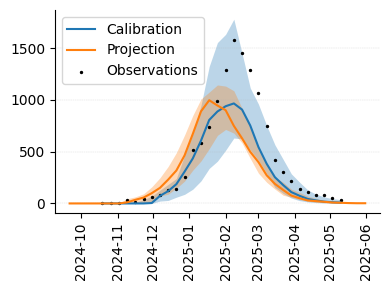

In [41]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

# ax.scatter(x, y, marker='o', lw=0)
plot_quantiles(
    calibration_quantiles,
    ax=ax,
    labels="Calibration",
    columns=["data"],
    colors="C0",
)

plot_quantiles(
    projection_quantiles,
    ax=ax,
    labels="Projection",
    columns=["hospitalizations"],
    colors="C1",
)

ax.scatter(
    calibration_quantiles['date'].unique(),
    runner_output_calibration0.results.observed_data['data'],
    color='black',
    label='Observations',
    s=2
)

ax.set_title("", loc='left')

ax.set_xlabel("")
ax.set_ylabel("")

ax.tick_params(axis='x', labelrotation=90)

ax.legend(loc='upper left', frameon=True)

fig.tight_layout()
plt.show()

## FluSight Format Output

In [24]:
pd.read_csv(StringIO(gzip.decompress(calibration_output_files["output_hub_formatted.csv.gz"]).decode()))

,location,reference_date,horizon,target_end_date,target,output_type,output_type_id,value
0,25,2025-04-05,-1,2025-03-29,wk inc flu hosp,quantile,0.01,102.0
1,25,2025-04-05,0,2025-04-05,wk inc flu hosp,quantile,0.01,63.0
2,25,2025-04-05,1,2025-04-12,wk inc flu hosp,quantile,0.01,35.0
3,25,2025-04-05,2,2025-04-19,wk inc flu hosp,quantile,0.01,20.0
4,25,2025-04-05,3,2025-04-26,wk inc flu hosp,quantile,0.01,10.0
...,...,...,...,...,...,...,...,...
130,25,2025-04-05,3,2025-04-26,wk flu hosp rate change,pmf,large_decrease,1.0
131,25,2025-04-05,3,2025-04-26,wk flu hosp rate change,pmf,stable,0.0
132,25,2025-04-05,3,2025-04-26,wk flu hosp rate change,pmf,increase,0.0
133,25,2025-04-05,3,2025-04-26,wk flu hosp rate change,pmf,decrease,0.0
